In [1]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rich import print
#from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde
from scipy.sparse import csr_matrix

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed

In [2]:
scvi.__version__

'1.0.2'

In [3]:
adata = sc.read_h5ad("data/adata/all.h5ad")
adata.X = csr_matrix(adata.X)
adata.layers["counts"] = adata.X.copy()

In [4]:
adata

AnnData object with n_obs × n_vars = 229041 × 36601
    obs: 'run', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'louvain', 'cluster', 'label', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Doublet_cluster', 'doublet', 'dead_cell', 'cc_phase', 'cc_score_S', 'cc_score_G2M', 'ann_singleR_encode', 'cell_type_singleR_encode', 'ann_singleR_HCA', 'cell_type_singleR_HCA', 'cell_type', 'sample', 'tissue', 'study', 'donor', 'TRA.1.v_gene', 'TRA.1.d_gene', 'TRA.1.j_gene', 'TRA.1.c_gene', 'TRA.1.cdr3', 'TRA.1.cdr3_nt', 'TRA.1.umis', 'TRA.1.reads', 'TRA.1.high_confidence', 'TRA.1.productive', 'TRA.1.full_length', 'TRA.1.raw_clonotype_id', 'TRA.2.v_gene', 'TRA.2.d_gene', 'TRA.2.j_gene', 'TRA.2.c_gene', 'TRA.2.cdr3', 'TRA.2.cdr3_nt', 'TRA.2.umis', 'TRA.2.reads', 'TRA.2.high_confidence', 'TRA.2.productive', 'TRA.2.full_length', 'TRA.2.raw_clonotype_id', 'TRB.1.v_gene', 'TRB.1.d_gene', 'TRB

In [5]:
adata.obs["Malignant_exp"] = adata.obs["Malignant"]
print(adata.obs["Malignant_exp"].value_counts())
adata.obs["Malignant_exp"][adata.obs["cell_type"].isin(["CD4+ T-cells", "CD8+ T-cells"]) & adata.obs["lesion"].isin(["Healthy"])] = "T cell"
print(adata.obs["Malignant_exp"].value_counts())

Malignant_exp
Unknown      179859
Malignant     29026
T cell        20156
Name: count, dtype: int64

Malignant_exp
Unknown      176519
Malignant     28994
T cell        23528
Name: count, dtype: int64

In [6]:
adata

AnnData object with n_obs × n_vars = 229041 × 36601
    obs: 'run', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'louvain', 'cluster', 'label', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Doublet_cluster', 'doublet', 'dead_cell', 'cc_phase', 'cc_score_S', 'cc_score_G2M', 'ann_singleR_encode', 'cell_type_singleR_encode', 'ann_singleR_HCA', 'cell_type_singleR_HCA', 'cell_type', 'sample', 'tissue', 'study', 'donor', 'TRA.1.v_gene', 'TRA.1.d_gene', 'TRA.1.j_gene', 'TRA.1.c_gene', 'TRA.1.cdr3', 'TRA.1.cdr3_nt', 'TRA.1.umis', 'TRA.1.reads', 'TRA.1.high_confidence', 'TRA.1.productive', 'TRA.1.full_length', 'TRA.1.raw_clonotype_id', 'TRA.2.v_gene', 'TRA.2.d_gene', 'TRA.2.j_gene', 'TRA.2.c_gene', 'TRA.2.cdr3', 'TRA.2.cdr3_nt', 'TRA.2.umis', 'TRA.2.reads', 'TRA.2.high_confidence', 'TRA.2.productive', 'TRA.2.full_length', 'TRA.2.raw_clonotype_id', 'TRB.1.v_gene', 'TRB.1.d_gene', 'TRB

In [7]:
gene_scores = pd.read_csv("data/gene_scores_5k_sum_skin.tsv", sep="\t")
gene_scores["gene"].values[:3000]
lineage_genes = pd.read_csv("data/skin_lineage_genes.tsv", sep="\t")
lineage_genes["x"].values
genes = np.append(gene_scores["gene"].values[:3000], lineage_genes["x"].values)
genes = np.intersect1d(genes, adata.var_names.values)
print(len(genes))
genes

2983

array(['A2M', 'A2ML1', 'A4GALT', ..., 'ZNF80', 'ZNRD1', 'ZWINT'],
      dtype=object)

In [8]:
adata = adata[:, genes].copy()

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [9]:
adata

AnnData object with n_obs × n_vars = 229041 × 2983
    obs: 'run', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'louvain', 'cluster', 'label', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Doublet_cluster', 'doublet', 'dead_cell', 'cc_phase', 'cc_score_S', 'cc_score_G2M', 'ann_singleR_encode', 'cell_type_singleR_encode', 'ann_singleR_HCA', 'cell_type_singleR_HCA', 'cell_type', 'sample', 'tissue', 'study', 'donor', 'TRA.1.v_gene', 'TRA.1.d_gene', 'TRA.1.j_gene', 'TRA.1.c_gene', 'TRA.1.cdr3', 'TRA.1.cdr3_nt', 'TRA.1.umis', 'TRA.1.reads', 'TRA.1.high_confidence', 'TRA.1.productive', 'TRA.1.full_length', 'TRA.1.raw_clonotype_id', 'TRA.2.v_gene', 'TRA.2.d_gene', 'TRA.2.j_gene', 'TRA.2.c_gene', 'TRA.2.cdr3', 'TRA.2.cdr3_nt', 'TRA.2.umis', 'TRA.2.reads', 'TRA.2.high_confidence', 'TRA.2.productive', 'TRA.2.full_length', 'TRA.2.raw_clonotype_id', 'TRB.1.v_gene', 'TRB.1.d_gene', 'TRB.

In [10]:
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    #categorical_covariate_keys=["run", "donor", "study"],
    categorical_covariate_keys=["run", "donor", "study", "chemistry"],
    continuous_covariate_keys=["cc_score_S", "cc_score_G2M"]
)

In [11]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [12]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 35/35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [14:04<00:00, 27.65s/it, v_num=1, train_loss_step=689, train_loss_epoch=637]

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 35/35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [14:04<00:00, 24.13s/it, v_num=1, train_loss_step=689, train_loss_epoch=637]


In [13]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [14]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
adata.obs["leiden_scVI"] = adata.obs["leiden"]

In [15]:
#adata.obsm["X_mde"] = mde(adata.obsm["X_scVI"])
sc.tl.umap(adata, min_dist=0.3)
adata.obsm["X_umap_scVI"] = adata.obsm["X_umap"]

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` paramete

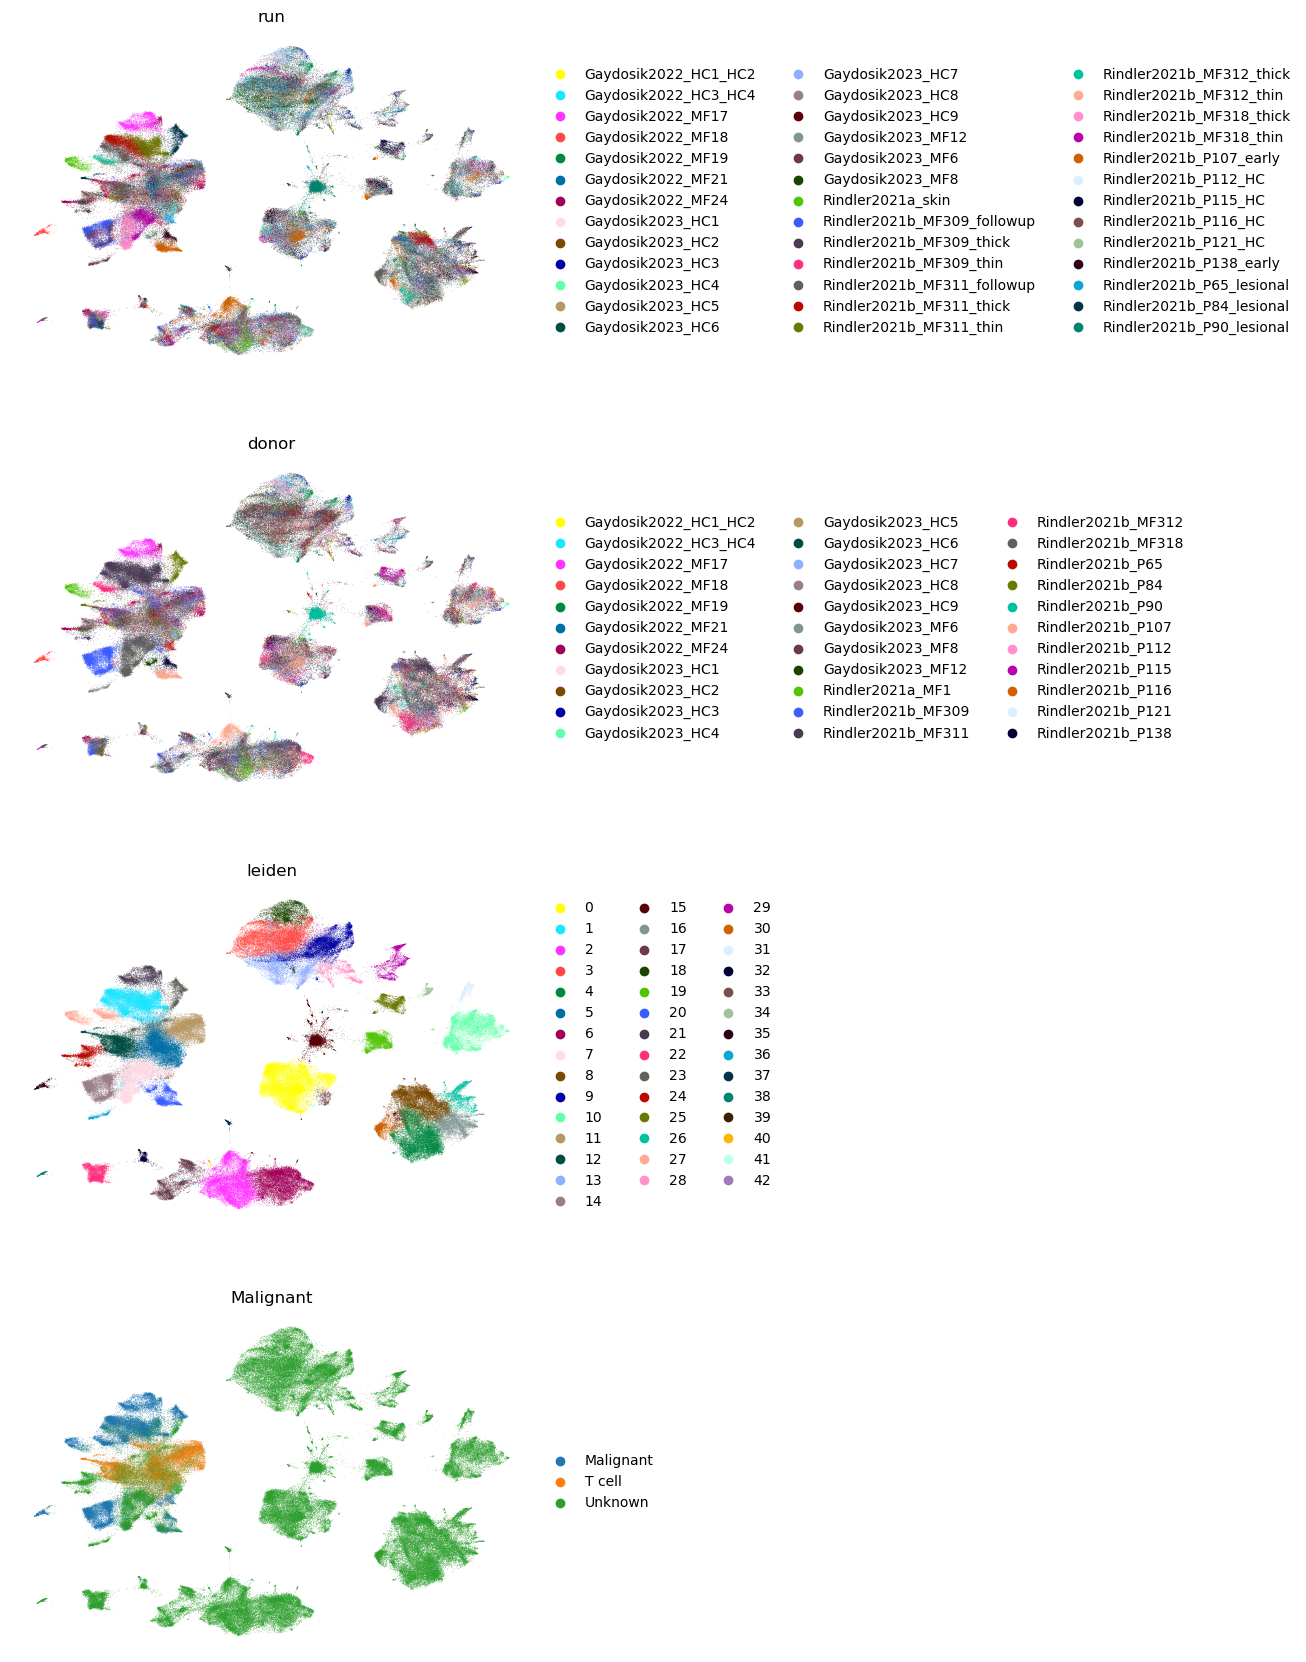

In [16]:
perm_inds = np.random.permutation(len(adata))
sc.pl.embedding(
    adata[perm_inds],
    basis="X_umap_scVI",
    color=["run", "donor", "leiden", "Malignant"],
    frameon=False,
    colorbar_loc=None,
    ncols=1,
)

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` paramete

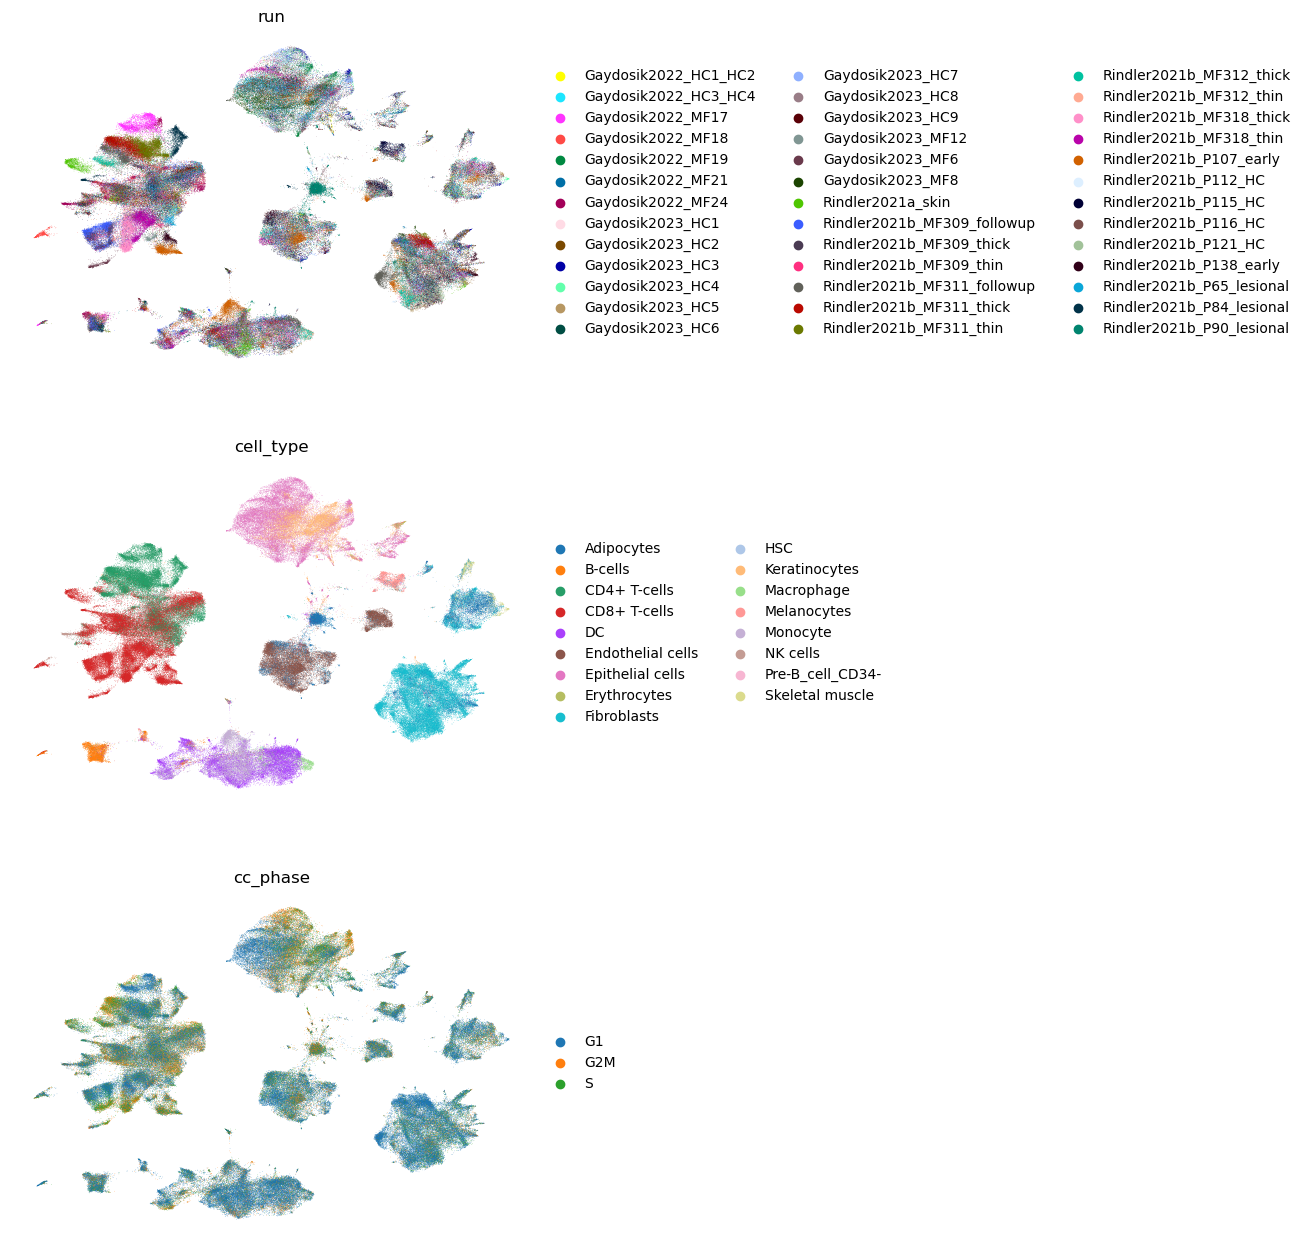

In [17]:
sc.pl.embedding(
    adata[perm_inds],
    basis="X_umap_scVI",
    color=["run", "cell_type", "cc_phase"],
    frameon=False,
    ncols=1,
)

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


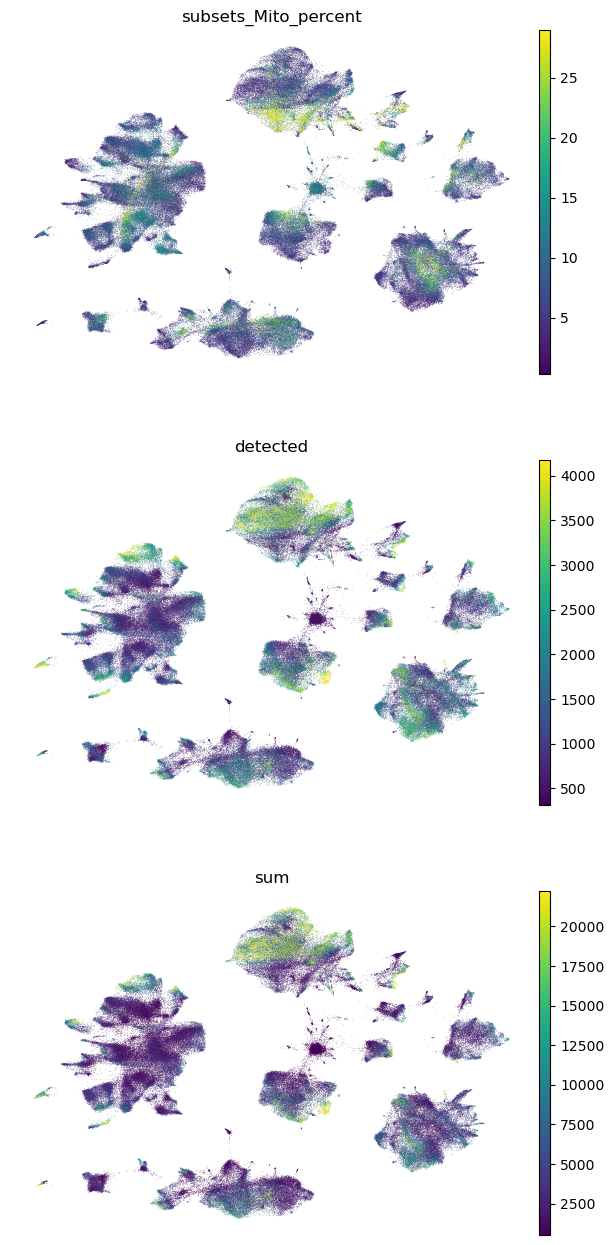

In [18]:
sc.pl.embedding(
    adata[perm_inds],
    basis="X_umap_scVI",
    color=["subsets_Mito_percent", "detected", "sum"],
    vmin="p1", 
    vmax="p98", 
    frameon=False,
    ncols=1,
)

In [19]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="Malignant_exp",
    unlabeled_category="Unknown",
)

In [20]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:23<00:00, 57.29s/it, v_num=1, train_loss_step=726, train_loss_epoch=645]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:23<00:00, 58.17s/it, v_num=1, train_loss_step=726, train_loss_epoch=645]


In [21]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [22]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.leiden(adata)
adata.obs["leiden_scANVI"] = adata.obs["leiden"]

In [23]:
sc.tl.umap(adata, min_dist=0.3)
adata.obsm["X_umap_scANVI"] = adata.obsm["X_umap"]

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` paramete

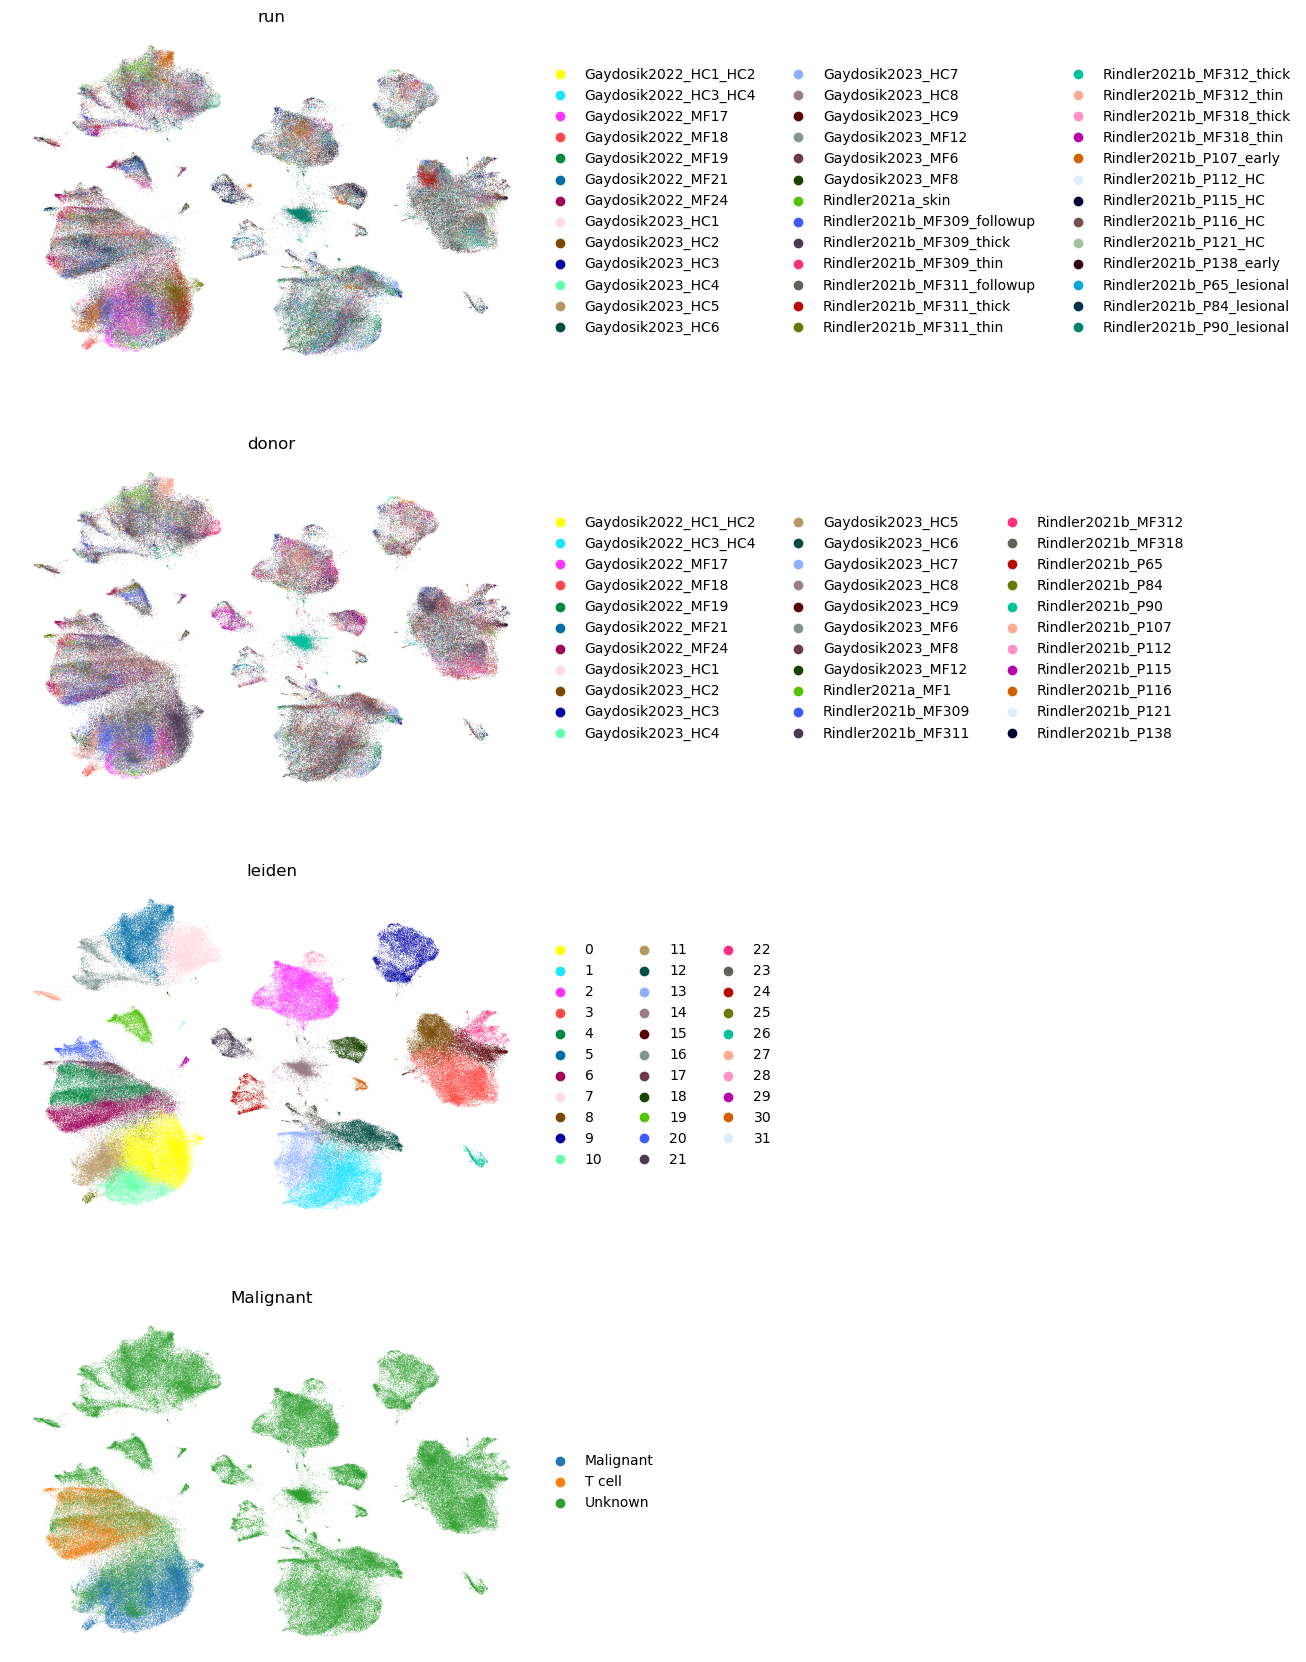

In [24]:
sc.pl.embedding(
    adata[perm_inds],
    basis="X_umap_scANVI",
    color=["run", "donor", "leiden", "Malignant"],
    frameon=False,
    colorbar_loc="None",
    ncols=1,
)

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` paramete

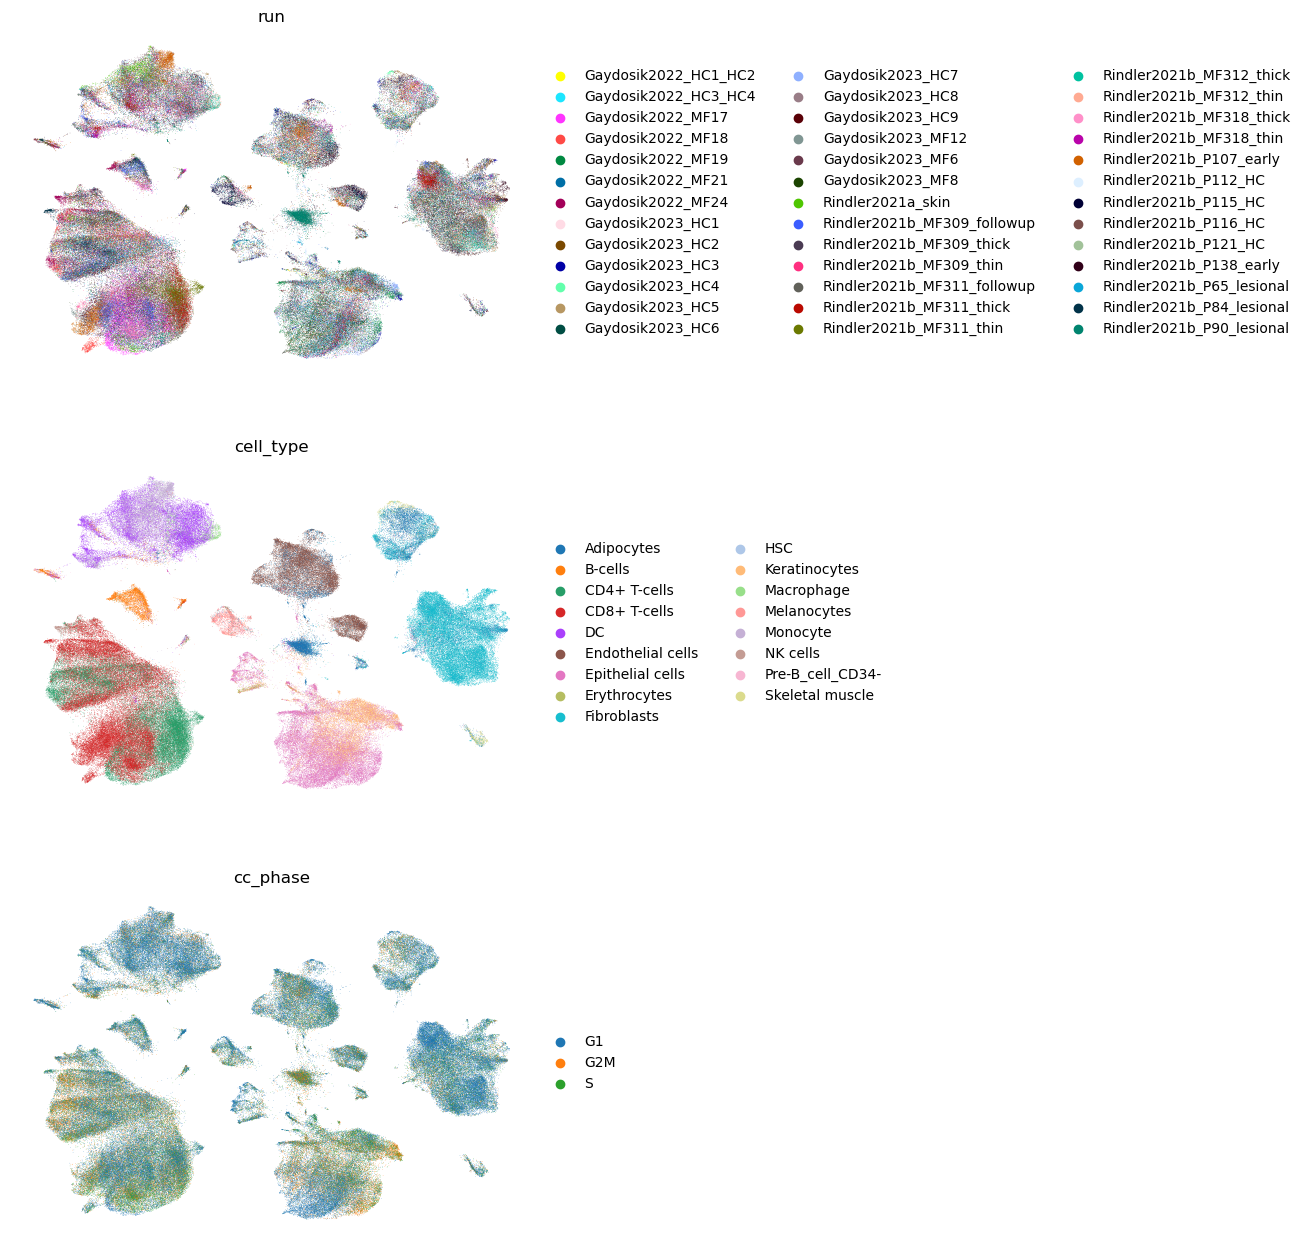

In [25]:
sc.pl.embedding(
    adata[perm_inds],
    basis="X_umap_scANVI",
    color=["run", "cell_type", "cc_phase"],
    frameon=False,
    ncols=1,
)

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


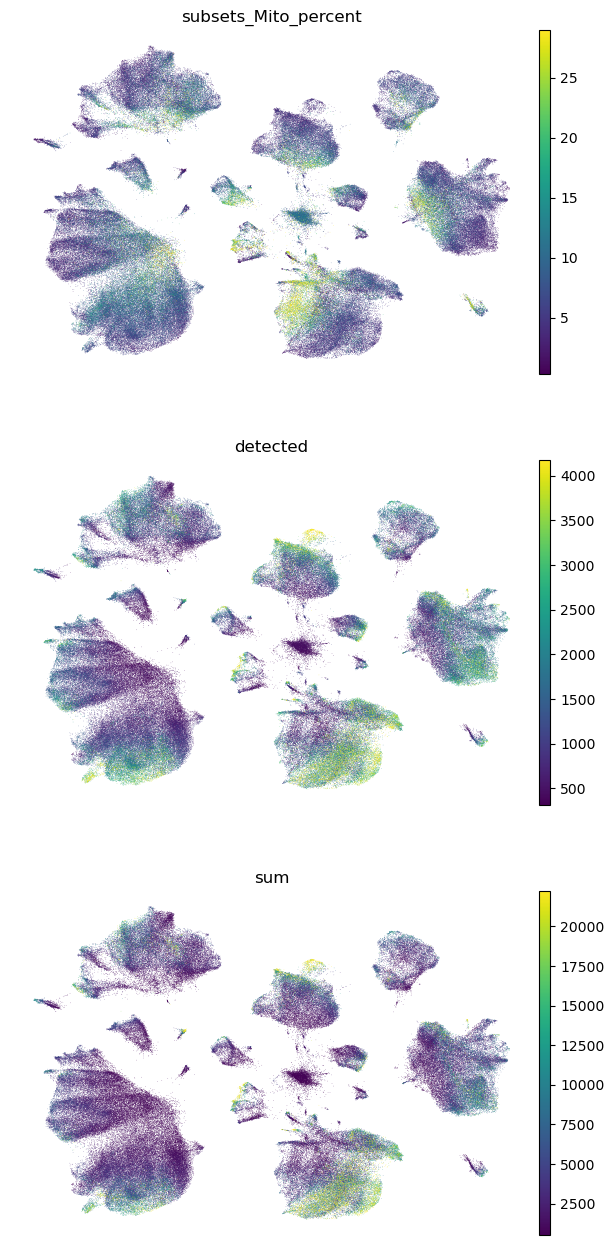

In [26]:
sc.pl.embedding(
    adata[perm_inds],
    basis="X_umap_scANVI",
    color=["subsets_Mito_percent", "detected", "sum"],
    vmin="p1", 
    vmax="p98", 
    frameon=False,
    ncols=1,
)

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


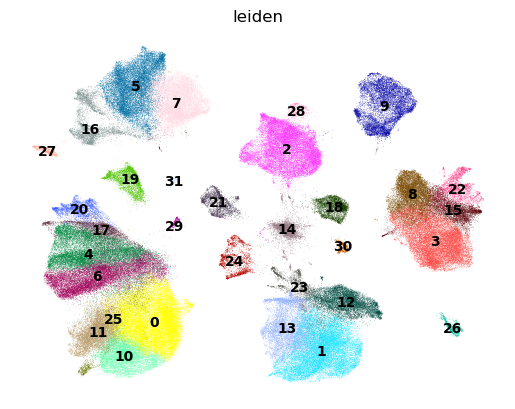

In [27]:
sc.pl.embedding(
    adata[perm_inds],
    basis="X_umap_scANVI",
    color=["leiden"],
    frameon=False,
    legend_loc="on data",
    ncols=1,
)

In [28]:
vae.save("data/scVI/skin_scVI_pre_filter", overwrite=True)
lvae.save("data/scVI/skin_scANVI_pre_filter", overwrite=True)
adata.write_h5ad("data/adata/skin_scANVI_pre_filter.h5ad")

In [29]:
adata = sc.read_h5ad("data/adata/skin_scANVI_pre_filter.h5ad")

In [30]:
vae = scvi.model.SCVI.load(adata=adata, dir_path="data/scVI/skin_scVI_pre_filter")
lvae = scvi.model.SCANVI.load(adata=adata, dir_path="data/scVI/skin_scANVI_pre_filter")

INFO     File data/scVI/skin_scVI_pre_filter/model.pt already downloaded                                           
INFO     File data/scVI/skin_scANVI_pre_filter/model.pt already downloaded                                         


In [31]:
sc.tl.leiden(adata, key_added="leiden_scANVI_02", resolution=0.2)
sc.tl.leiden(adata, key_added="leiden_scANVI_03", resolution=0.3)
sc.tl.leiden(adata, key_added="leiden_scANVI_04", resolution=0.4)
sc.tl.leiden(adata, key_added="leiden_scANVI_05", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_scANVI_07", resolution=0.7)
sc.tl.leiden(adata, key_added="leiden_scANVI_10", resolution=1.0)
sc.tl.leiden(adata, key_added="leiden_scANVI_15", resolution=1.5)
sc.tl.leiden(adata, key_added="leiden_scANVI_20", resolution=2.0)

/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/tbb/mambaforge-pypy3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` paramete

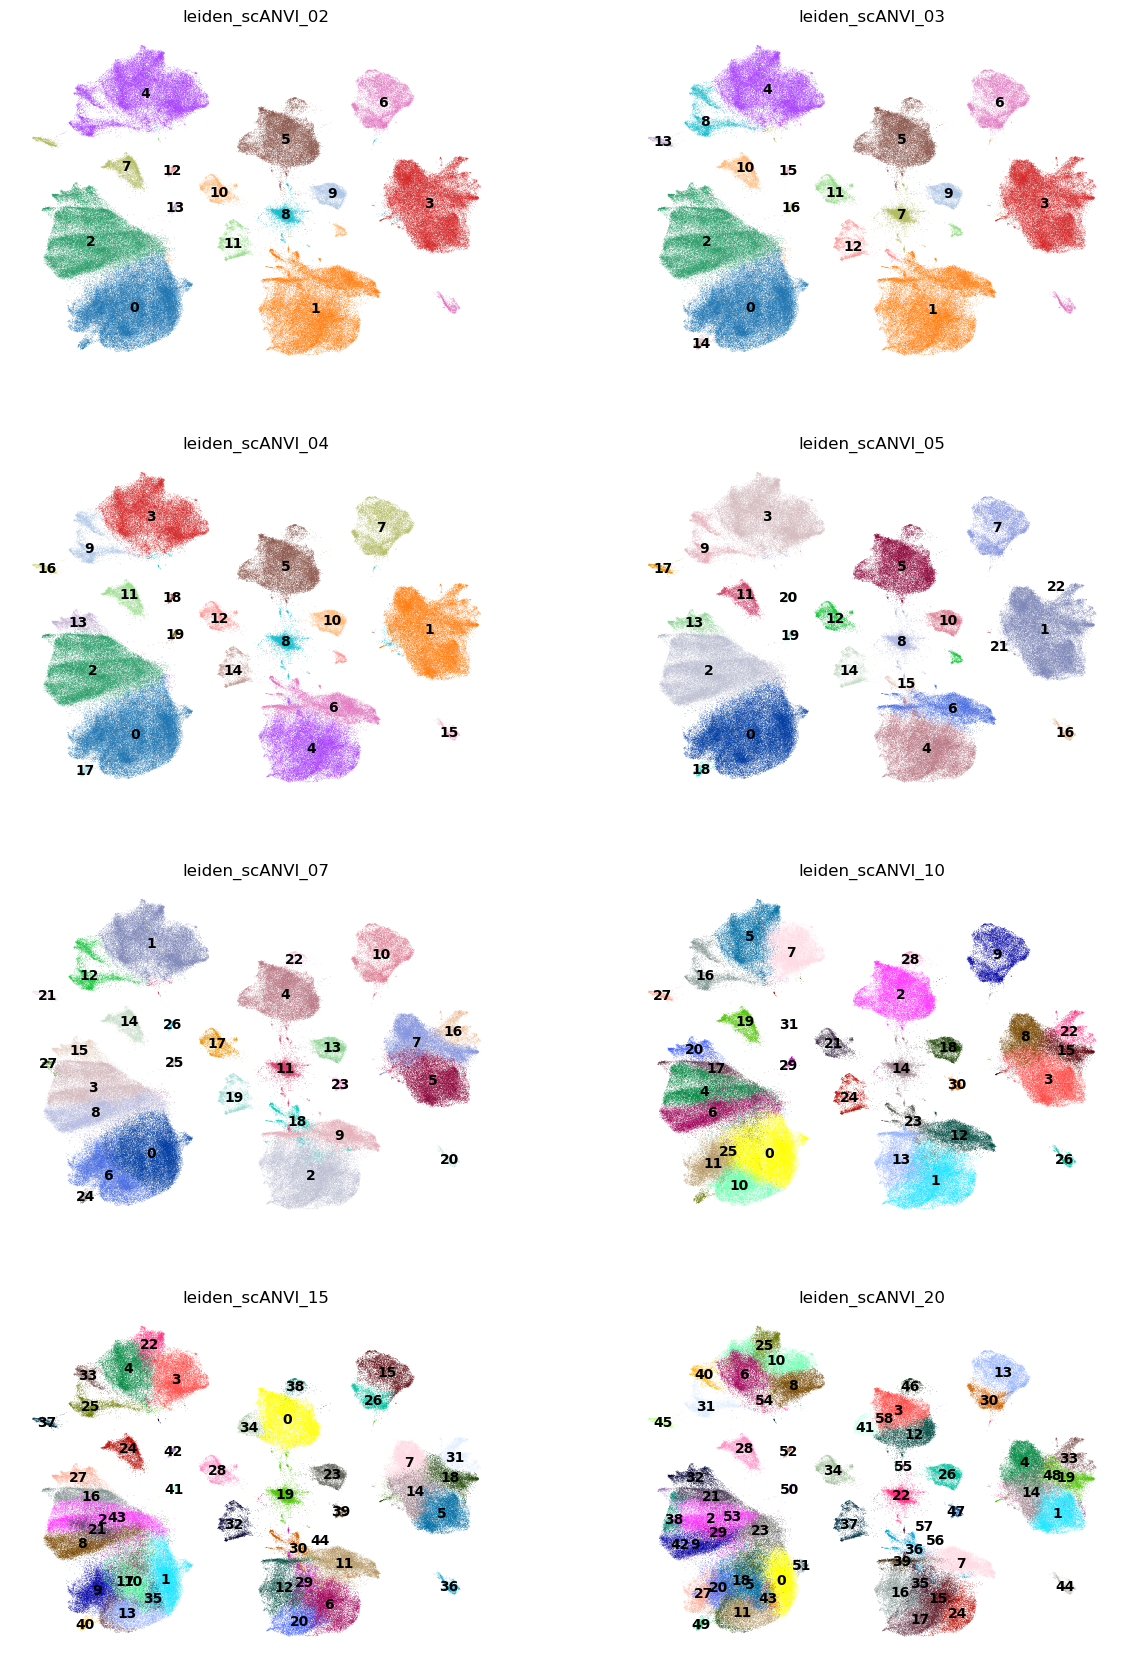

In [32]:

sc.pl.embedding(
    adata[perm_inds],
    basis="X_umap_scANVI",
    color=["leiden_scANVI_02", "leiden_scANVI_03", "leiden_scANVI_04", "leiden_scANVI_05", "leiden_scANVI_07", "leiden_scANVI_10", "leiden_scANVI_15", "leiden_scANVI_20"],
    legend_loc="on data",
    frameon=False,
    ncols=2,
)

In [33]:
adata.layers["scvi_normalized"] = lvae.get_normalized_expression(library_size=10e4)

In [34]:
adata.write_h5ad("data/adata/skin_scANVI.h5ad")